In [1]:
import pandas as pd
import numpy as np
import dlib
from imutils import face_utils
import config as Config
import src.utils as Utils
import cv2
import random
import joblib
from matplotlib import pyplot as plt

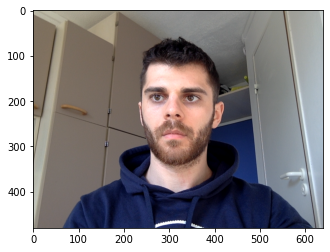

In [2]:
cv2_image = cv2.imread('./data/images/1_110.png')
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
plt.imshow(cv2_image)

In [3]:
face_detector = dlib.get_frontal_face_detector()
face_predictor = dlib.shape_predictor(Config.face_landmarks_path)

In [4]:
gray_image = Utils.convert_to_gray_image(cv2_image)

In [5]:
rects = face_detector(gray_image, 0)
shape = face_predictor(gray_image, rects[0])
shape = face_utils.shape_to_np(shape)

In [6]:
(left_eye_start, left_eye_end) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(right_eye_start, right_eye_end) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

In [7]:
start, end = min(left_eye_start, right_eye_start), max(left_eye_end, right_eye_end)
# get the contour
strip = shape[start:end]
# get the upper left point, lower right point
start = [min(strip, key = lambda x: x[0])[0], min(strip, key = lambda x: x[1])[1]]
end = [max(strip, key = lambda x: x[0])[0], max(strip, key = lambda x: x[1])[1]]

(15, 104, 3)


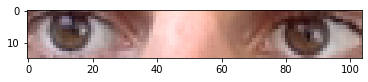

In [8]:
# get the image
strip = cv2_image[start[1]:end[1], start[0]:end[0]]
plt.imshow(strip)
print (strip.shape)

In [9]:
# go a little bit outside the bounding box
print (start, end)
distance = (end[0] - start[0], end[1] - start[1])
percents = [20, 60]
for i in range (0, 2):
    start[i] -= int(percents[i]/100 * distance[i])
    end[i] += int(percents[i]/100 * distance[i])
print (start, end)

[261, 186] [365, 201]
[241, 177] [385, 210]


(33, 144, 3)


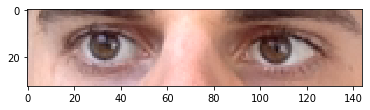

In [10]:
strip = cv2_image[start[1]:end[1], start[0]:end[0]]
plt.imshow(strip)
print (strip.shape)

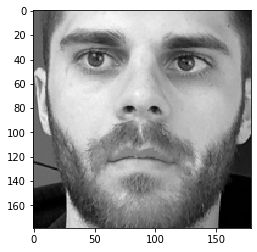

In [11]:
cv2_image = cv2.imread('./report/images/extracted_face.png')
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2_image, cmap='gray')

# Extracting thresholded eyes

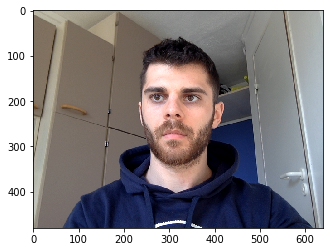

In [12]:
cv2_image = cv2.imread('./data/images/1_110.png')
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
plt.imshow(cv2_image)

In [72]:
face_detector = dlib.get_frontal_face_detector()
face_predictor = dlib.shape_predictor(Config.face_landmarks_path)

In [73]:
gray_image = Utils.convert_to_gray_image(cv2_image)
rects = face_detector(gray_image, 0)

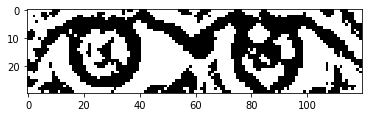

In [80]:
shape = face_predictor(gray_image, rects[0])
shape = face_utils.shape_to_np(shape)

eyes = []
for eye in ["left_eye", "right_eye"]:
    # get the points for the contour
    (eye_start, eye_end) = face_utils.FACIAL_LANDMARKS_IDXS[eye]
    contour = shape[eye_start:eye_end]
    # get the upper left point, lower right point for this eye
    start = [min(contour, key=lambda x: x[0])[0],
             min(contour, key=lambda x: x[1])[1]]
    end = [max(contour, key=lambda x: x[0])[0],
           max(contour, key=lambda x: x[1])[1]]
    eyes.append(cv2_image[start[1]:end[1], start[0]:end[0]])
    
    
# merge the eyes
for j in range(0, 2):
    eyes[j] = Utils.resize_cv2_image(eyes[j], fixed_dim=(
        Config.EYE_WIDTH, Config.EYE_HEIGHT))

eyes = np.concatenate((eyes[0], eyes[1]), axis=1)
eyes = Utils.get_binary_thresholded_image(eyes)
plt.imshow(eyes, cmap='gray')

# Get heatmap from eye

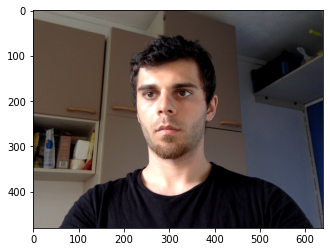

In [16]:
cv2_image = cv2.imread('./data/images/9_110.png')
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
plt.imshow(cv2_image)

In [20]:
from src.face_detector import extract_eyes

In [29]:
eyes = extract_eyes(cv2_image)

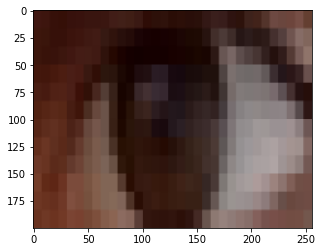

In [30]:
eye = Utils.resize_cv2_image(eyes[0], fixed_dim=(256, 200))
plt.imshow(eye)

In [41]:
# Step 2. Build the CNN architecture. Input: eye image. Output: heatmap.
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class MyCNN(nn.Module):
    def __init__(self, input_size):
        super(MyCNN, self).__init__()
        ## eye image -> encoder -> decoder -> heatmap
        ## input: 200 x 256
        
        filters = [16, 32, 64, 128]
        
        # starting encoding
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, filters[0], kernel_size=3, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[0]),
            
            nn.Conv2d(filters[0], filters[1], kernel_size=2, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[1]),
            
            nn.Conv2d(filters[1], filters[2], kernel_size=3, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[2]),
            
            nn.Conv2d(filters[2], filters[3], kernel_size=2, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[3]),
        )
        # encoding done
        # starting decoding
        self.layer2 = nn.Sequential(
            nn.Upsample(size=(28, 35), mode='bilinear'),
            nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[2]),
            
            nn.Upsample(size=(54, 68), mode='bilinear'),
            nn.ConvTranspose2d(filters[2], filters[1], kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[1]),
            
            nn.Upsample(size=(104, 132), mode='bilinear'),
            nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters[0]),
        
            nn.Upsample(size=(202, 258), mode='bilinear'),
            nn.ConvTranspose2d(filters[0], 1, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1),
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return (x)

In [55]:
import torch
model = MyCNN((200, 256))
model.load_state_dict(torch.load('./models/pytorch_200_256_hourglass_4'))
model.eval()

RuntimeError: Error(s) in loading state_dict for MyCNN:
	size mismatch for layer2.9.weight: copying a param with shape torch.Size([32, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 16, 2, 2]).
	size mismatch for layer2.13.weight: copying a param with shape torch.Size([1, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3]).

odict_keys(['layer1.0.weight', 'layer1.0.bias', 'layer1.3.weight', 'layer1.3.bias', 'layer1.3.running_mean', 'layer1.3.running_var', 'layer1.3.num_batches_tracked', 'layer1.4.weight', 'layer1.4.bias', 'layer1.7.weight', 'layer1.7.bias', 'layer1.7.running_mean', 'layer1.7.running_var', 'layer1.7.num_batches_tracked', 'layer1.8.weight', 'layer1.8.bias', 'layer1.11.weight', 'layer1.11.bias', 'layer1.11.running_mean', 'layer1.11.running_var', 'layer1.11.num_batches_tracked', 'layer1.12.weight', 'layer1.12.bias', 'layer1.15.weight', 'layer1.15.bias', 'layer1.15.running_mean', 'layer1.15.running_var', 'layer1.15.num_batches_tracked', 'layer2.1.weight', 'layer2.1.bias', 'layer2.3.weight', 'layer2.3.bias', 'layer2.3.running_mean', 'layer2.3.running_var', 'layer2.3.num_batches_tracked', 'layer2.5.weight', 'layer2.5.bias', 'layer2.7.weight', 'layer2.7.bias', 'layer2.7.running_mean', 'layer2.7.running_var', 'layer2.7.num_batches_tracked', 'layer2.9.weight', 'layer2.9.bias', 'layer2.11.weight', 'l